# Approximating likelihood ratios with calibrated classifiers

Gilles Louppe, January 2016.


In [52]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

## Toy problem

Let us consider two 1D distributions $p_0$ and $p_1$ for which we want to approximate the ratio $r(x) = \frac{p_0(x)}{p_1(x)}$ of their densities.

- $p_1$ is defined as a mixture of two gaussians;
- $p_0$ is defined as a mixture of the same two gaussians + a bump.

In [53]:
from carl.distributions import Normal
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75, random_state=0),   # c0
    Normal(mu=0.0, sigma=2.0, random_state=1),     # c1
    Normal(mu=1.0, sigma=0.5, random_state=3)      # c2 (bump)
]

bump_coefficient = 0.05
g = theano.shared(bump_coefficient) 
p0 = Mixture(components=components, weights=[0.5 - g / 2., 0.5 - g / 2., g], random_state=10)
p1 = Mixture(components=components[:2], weights=[0.5, 0.5], random_state=11)

/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +
/home/gilles/anaconda3/envs/carl/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
/home/gilles/anaconda3/envs/carl/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


Note: for $p_0$, weights are all tied together through the Theano shared variable `g`. This means that changes to the value stored in `g` also automatically change the weight values and the resulting mixture.

In [54]:
X_true = p0.rvs(5000)

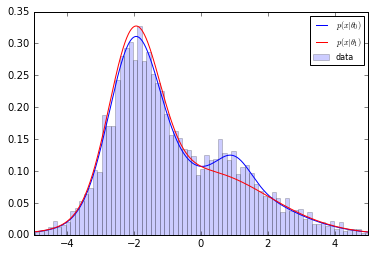

In [55]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_0)$", color="b")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_1)$", color="r")
plt.hist(X_true[:, 0], bins=100, normed=True, label="data", alpha=0.2, color="b")
plt.xlim(-5, 5)
plt.legend(loc="best", prop={'size': 8})
plt.savefig("fig1.pdf")
plt.show()

## Density ratio estimation

The density ratio $r(x)$ can be approximated using calibrated classifiers, either directly by learning to classify $x \sim p_0$ from $x \sim p_1$, or by decomposing the ratio of the two mixtures as pairs of simpler density ratios.

In [56]:
from sklearn.model_selection import GridSearchCV
from carl.ratios import CalibratedClassifierRatio
from carl.ratios.cc import as_classifier

# Classifier
# from sklearn.linear_model import ElasticNetCV
# clf = ElasticNetCV()

from sklearn.neural_network import MLPRegressor
clf = as_classifier(GridSearchCV(
    MLPRegressor(random_state=2),
    param_grid={
        "activation": ["tanh"],
        "hidden_layer_sizes": [(20, 20), (30, 30), (40, 40), (50, 50)],
        "learning_rate": ["adaptive", "invscaling", "constant"]
    },
    scoring="mean_squared_error",
    verbose=3),
)

# from sklearn.ensemble import ExtraTreesRegressor
# clf = as_classifier(GridSearchCV(
#     ExtraTreesRegressor(random_state=1),
#     param_grid={
#         "n_estimators": [250],
#         "max_leaf_nodes": list(range(2, 20))
#     },
#     scoring="mean_squared_error")
# )

# Calibration scheme
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_iter=3, test_size=0.8, random_state=0)  # one split, 25% for training, 75% for calibration

# No calibration
cc_none = CalibratedClassifierRatio(base_estimator=clf, cv=cv, calibration=None)
cc_none.fit(numerator=p0, denominator=p1, n_samples=100000)

# Calibration + Direct approximation 
cc_direct = CalibratedClassifierRatio(base_estimator=clf, cv=cv)
cc_direct.fit(numerator=p0, denominator=p1, n_samples=100000)

# Calibration + Decomposition of the mixture
from carl.ratios import DecomposedRatio
cc_decomposed = DecomposedRatio(CalibratedClassifierRatio(base_estimator=clf, cv=cv))
cc_decomposed.fit(numerator=p0, denominator=p1, n_samples=100000)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250472 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.252104 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250667 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.250472 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.252104 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=inv

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   15.4s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   19.2s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250112 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.249748 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.251728 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.250112 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.249748 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   15.9s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   19.6s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250477 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.251393 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250581 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.250477 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.251393 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   16.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   19.9s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250472 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.252104 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250667 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.250472 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.252104 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   16.9s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   20.7s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250112 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.249748 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.251728 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.250112 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.249748 -   0.5s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   16.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   20.3s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250477 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.251393 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.250581 -   0.5s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.250477 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.251393 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   15.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   18.8s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.145776 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.136750 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.143614 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.145776 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.136750 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   11.3s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.144414 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.137258 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.143012 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.144414 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.137258 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   11.9s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.138708 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.148057 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.128472 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.138708 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.148057 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   12.6s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.011814 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.011447 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.011998 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.011814 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.011447 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   12.9s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   17.6s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.008813 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.011181 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.010478 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.008813 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.011181 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   12.9s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   17.3s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.010505 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.007839 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.012347 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.010505 -   0.2s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.007839 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   13.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   18.1s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.135282 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.142174 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.137998 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.135282 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.142174 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   12.4s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   16.5s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.125757 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.141083 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.139590 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.125757 -   0.4s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.141083 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   20.0s finished



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.135228 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.135753 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=adaptive, activation=tanh, score=-0.150513 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.135228 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh 
[CV]  hidden_layer_sizes=(20, 20), learning_rate=invscaling, activation=tanh, score=-0.135753 -   0.3s
[CV] hidden_layer_sizes=(20, 20), learning_rate=in

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   13.6s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   17.6s finished


DecomposedRatio(base_ratio=CalibratedClassifierRatio(base_estimator=Wrapper(base_estimator=GridSearchCV(cv=None, error_score='raise',
       estimator=MLPRegressor(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_l...    cv=StratifiedShuffleSplit(n_iter=3, random_state=0, test_size=0.8,
            train_size=None)))

Note: `CalibratedClassifierRatio` takes three arguments for controlling its execution:
- `base_estimator` specifying the classifier to be used,
- `calibration` specifying the calibration algorithm (`"kde"`, `"histogram"`, or a user-defined distribution-like object),
- `cv` specifying how to allocate data for training and calibration.

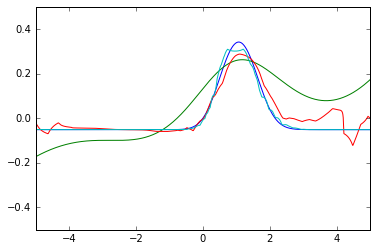

In [57]:
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")

plt.plot(reals, np.log(cc_none.predict(reals.reshape(-1, 1), log=True)), label="No calibration")
plt.plot(reals, cc_direct.predict(reals.reshape(-1, 1), log=True), label="Calibration")
plt.plot(reals, cc_decomposed.predict(reals.reshape(-1, 1), log=True), label="Calibration + Decomposition")

plt.xlim(-5, 5)
plt.ylim(-0.5, 0.5)
#plt.legend(loc="best", prop={'size': 8})
plt.savefig("fig2-mlp.pdf")
plt.show()

Note: For `CalibratedClassifierRatio` objects, the `calibrators_` attribute stores a list of pairs of calibrators (one pair per CV fold). Calibrators implement the `carl.distributions.DistributionMixin` interface and can be used as distributions. For `DecomposedRatio` objects, the `ratios_` attribute stores a dictionary of pairwise ratios modelled from the mixture components. Together, these attributes can be used for inspection, as illustrated below:

In [ ]:
reals = np.linspace(0, 1)

for (j, i), r in sorted(cc_decomposed.ratios_.items()):
    if i != j and isinstance(r, CalibratedClassifierRatio):
        cal_num, cal_den = r.calibrators_[0]
        plt.plot(reals, cal_num.pdf(reals.reshape(-1, 1)), 
                 label="p(s_num=c%d,den=c%d(x)), x~c%d" % (j, i, j))
        plt.plot(reals, cal_den.pdf(reals.reshape(-1, 1)), 
                 label="p(s_num=c%d,den=c%d(x)), x~c%d" % (j, i, i))
        plt.legend()
        plt.show()

## Using density ratios for maximum likelihood fit

In the likelihood-free setting, density ratios can be used to find the maximum likelihood estimator $\theta^* = \arg \max_{\theta} p(D | \theta)$ by noticing that $\theta^*$ also maximizes $\prod_{x \in D} \frac{p(x|\theta)}{p(x|\theta_1)}$ for some fixed value of $\theta_1$.

As an example, this can be used to find the bump coefficient in $p_1$, as illustrated below:

In [58]:
# from sklearn.linear_model import ElasticNetCV
# cc = DecomposedRatio(CalibratedClassifierRatio(base_estimator=ElasticNetCV(), cv=cv))
# cc.fit(numerator=p0, denominator=p1, n_samples=50000)

cc = cc_decomposed

def objective(theta):       
    g.set_value(theta[0])  # this indirectly updates weights in p1, 
                           # along with the density ratios computed by cc 
                           # (without having to retrain the classifiers since 
                           # g only affects the weights!)
        
    return -np.mean(cc.predict(X_true, log=True))

from scipy.optimize import minimize
results = minimize(objective, x0=[0.1], 
                   constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

print("Bump coefficient =", bump_coefficient)
print("Found minimum =", results.x[0])

Bump coefficient = 0.05
Found minimum = 0.0475201203461


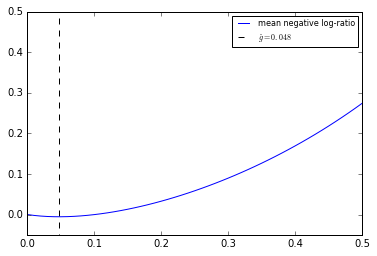

In [59]:
thetas = np.linspace(0., 0.5, num=51)
obj = [objective([theta]) for theta in thetas]

plt.plot(thetas, obj, label="mean negative log-ratio")
plt.vlines(results.x, -5, 5, linestyles="dashed", label=r"$\hat g = %.3f$" % results.x[0])
plt.ylim(-0.05, 0.5)
plt.legend(prop={'size': 8})
plt.savefig("fig3.pdf")
plt.show()